# Hackathon Demo: Multi-Modal MRI Loading, Visualisation & Alignment

**SussexAI Medical AI Track**

This notebook teaches you how to:
1. **Load** NIfTI files from two MRI modalities (64mT Hyperfine and 3T)
2. **Visualise** each volume as 2D slices
3. **Align** both modalities into the same coordinate grid using registration
4. **Save** individual slices as PNG images for downstream tasks

---
## 1. Setup

Install the required packages. `-q` installs the package silently so you will only see minimal output. For this notebook to work, you will need to download the MNI152 T1w atlas image from here: [Atlas file](http://www.bic.mni.mcgill.ca/~vfonov/icbm/2009/mni_icbm152_nlin_sym_09a_nifti.zip). Once you unpack the file, the file necessary for this notebook is called **"mni_icbm152_t1_tal_nlin_sym_09a"**. Please store this file somewhere where you have access to it in your file system. The data can be downloaded from [here](https://zenodo.org/records/15374450). The easiest way to get the data is to use `uvx` from the [uv dependency manager](https://docs.astral.sh/uv/getting-started/installation/) and the [zenodo_get](https://github.com/dvolgyes/zenodo_get).

The command you will need is `uvx zenodo_get RECORD_ID_OR_DOI` and the DOI can be fetched from the zenodo repository [here](https://zenodo.org/records/15374450)

In [22]:
%pip install -q antspyx nibabel matplotlib numpy

import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

Note: you may need to restart the kernel to use updated packages.


In [23]:
# set the data directory

# set the path to the downloaded directory from zenodo here
DATA_DIR = Path('/Users/luca/Downloads/HackathonPaired')

example_3T_file = os.path.join(DATA_DIR / 'Data' / '3T data' / 'sub-0047' / 'anat' / 'sub-0047_acq-highres_T1w.nii.gz')

example_64mT_file = os.path.join(DATA_DIR / 'Data' / '64mT data' / 'sub-0047' / 'ses-01' / 'anat' / 'sub-0047_ses-01_run-1_T1w.nii.gz')

# set the atlas path to the atlas file 
ATLAS_PATH = os.path.join(DATA_DIR / "Atlas" / "mni_icbm152_t1.nii")

# set the outout directory path
OUT_DIR = os.path.join(DATA_DIR / "outouts")

print(DATA_DIR)
print(ATLAS_PATH)
print(OUT_DIR)

/Users/luca/Downloads/HackathonPaired
/Users/luca/Downloads/HackathonPaired/Atlas/mni_icbm152_t1.nii
/Users/luca/Downloads/HackathonPaired/outouts


---
## 2. Visualise Each Volume

In this track, we use two different image modalities of the same subject for computer vision /  biomedical imaging challenge. The image modalities we're working with are 3 Tesla high-field MRI images and 64mT ultra-low-field MRI images. 

Any MRI data volume is a three-dimensional tensor. Depending on how the tensor is indexed, you either get axial, coronal or sagittal slices. here we display axial slices (along the z-axis) from both modalities. Slices are indexed as `data[:, :, slice_idx]`.

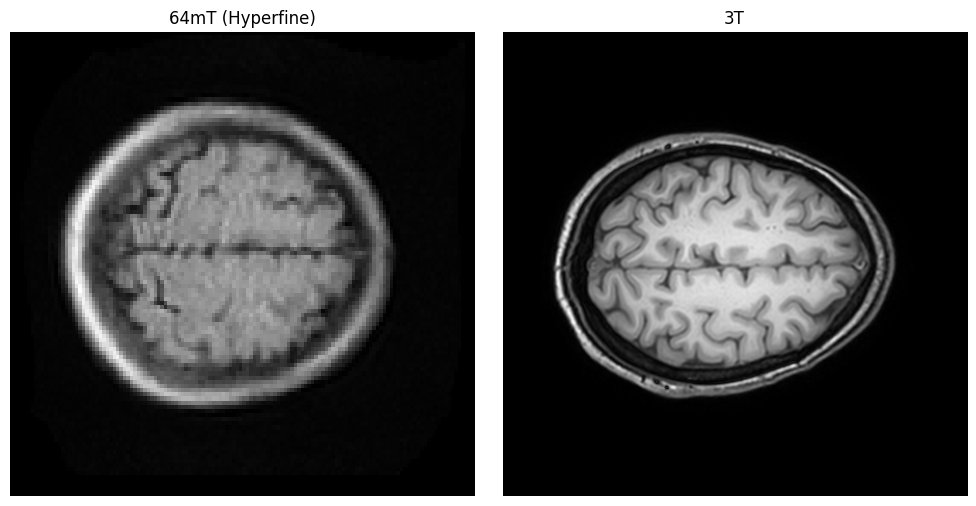

In [24]:
def load_nii_file(file_path):
    """Load a NIfTI file and return a nibabel image object."""
    return nib.load(file_path)


# Load example volumes
img_64mT = load_nii_file(example_64mT_file)
img_3T = load_nii_file(example_3T_file)

# Extract numpy arrays (shape: x, y, z)
data_64mT = img_64mT.get_fdata()
data_3T = img_3T.get_fdata()

# Visualise a single slice from each modality
slice_idx = 30  # Adjust to explore different slices

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(data_64mT[:, :, slice_idx], cmap='gray', interpolation="nearest", aspect='auto')   
axes[0].set_box_aspect(1) 
axes[0].set_title('64mT (Hyperfine)')
axes[0].axis('off')

# the 3T volume has a different resolution, with more voxels so the slice index
# needs to be changed. 
slice_idx = 110
axes[1].imshow(data_3T[:, :, slice_idx], cmap='gray') 
axes[1].set_title('3T')
axes[1].axis('off')
plt.tight_layout()
plt.show()

As you can see from the images above, the images look quite differently and have different dimensions. To be able to work with them effectively, we need to align them into a shared coordinate system. 

---
## 3. Align Into the Same Coordinate Grid

To use the data acquired at 64mT and 3T we need to align the anatomical structures in the different modalities. Image registration is a techniques that helps us to acheives this alignment. [ANTsPy](https://antspy.readthedocs.io/en/stable/) is a python library that contains tools that register the 64mT volume into the 3T space. The specifics of the registration process are not increadibly important to understand for the Hackathon, but for the interested reader the process is outlined briefly. 

To achieve a good registration result with varying starting dimensionality for both the 3T and 64mT volumes we use a reference atlas image with isotropic (equally) sized voxels as our template coordinate space. To move both images into the reference space we do the following steps: 

1. Register the 3T image into the Atlas coordinate system
2. Register the 64mT image into the 3T image
3. Compose both transformation matrices to register the 64mT image into the atlas coordinate space. 

The output we then obtain are two transformed images A) the 3T image on the altas coordinate system and the 64mT image in the atlas coordinate system. 

In [ ]:
def register_into_atlas_coordinate_system(path_to_atlas, file_path_3T, file_path_64mT):
    """
    Registers the 3T and 64mT images into the atlas coordinate system.

    Args:
        path_to_atlas (str): Path to the atlas file.
        file_path_3T (str): Path to the 3T image file.
        file_path_64mT (str): Path to the 64mT image file.

    Returns:
        registered_64mT (ants.ANTsImage): The 64mT image registered to the atlas coordinate system.
        registered_3T (ants.ANTsImage): The 3T image registered to the atlas coordinate system.
    """
    template = ants.image_read(path_to_atlas)
    img_T3 = ants.image_read(file_path_3T)
    img_64mT = ants.image_read(file_path_64mT)


    # Register 3T→Atlas and 64mT→3T
    reg12 = ants.registration(template, img_T3, 'Affine')
    reg23 = ants.registration(img_T3, img_64mT, 'Similarity')

    # Concatenate transforms (order matters here!)
    mytx = reg12['fwdtransforms'] + reg23['fwdtransforms']

    registered_64mT = ants.apply_transforms(
        fixed=template,
        moving=img_64mT,
        transformlist=mytx,
        interpolator='bSpline'
    )

    registered_3T = ants.apply_transforms(
        fixed=template,
        moving=img_T3,
        transformlist=reg12['fwdtransforms'],
        interpolator='bSpline'
    )

    return registered_64mT, registered_3T


registered_64mT, registered_3T = register_into_atlas_coordinate_system(
    ATLAS_PATH,
    example_3T_file,
    example_64mT_file
    )

We can now see how the images look post-registration. 

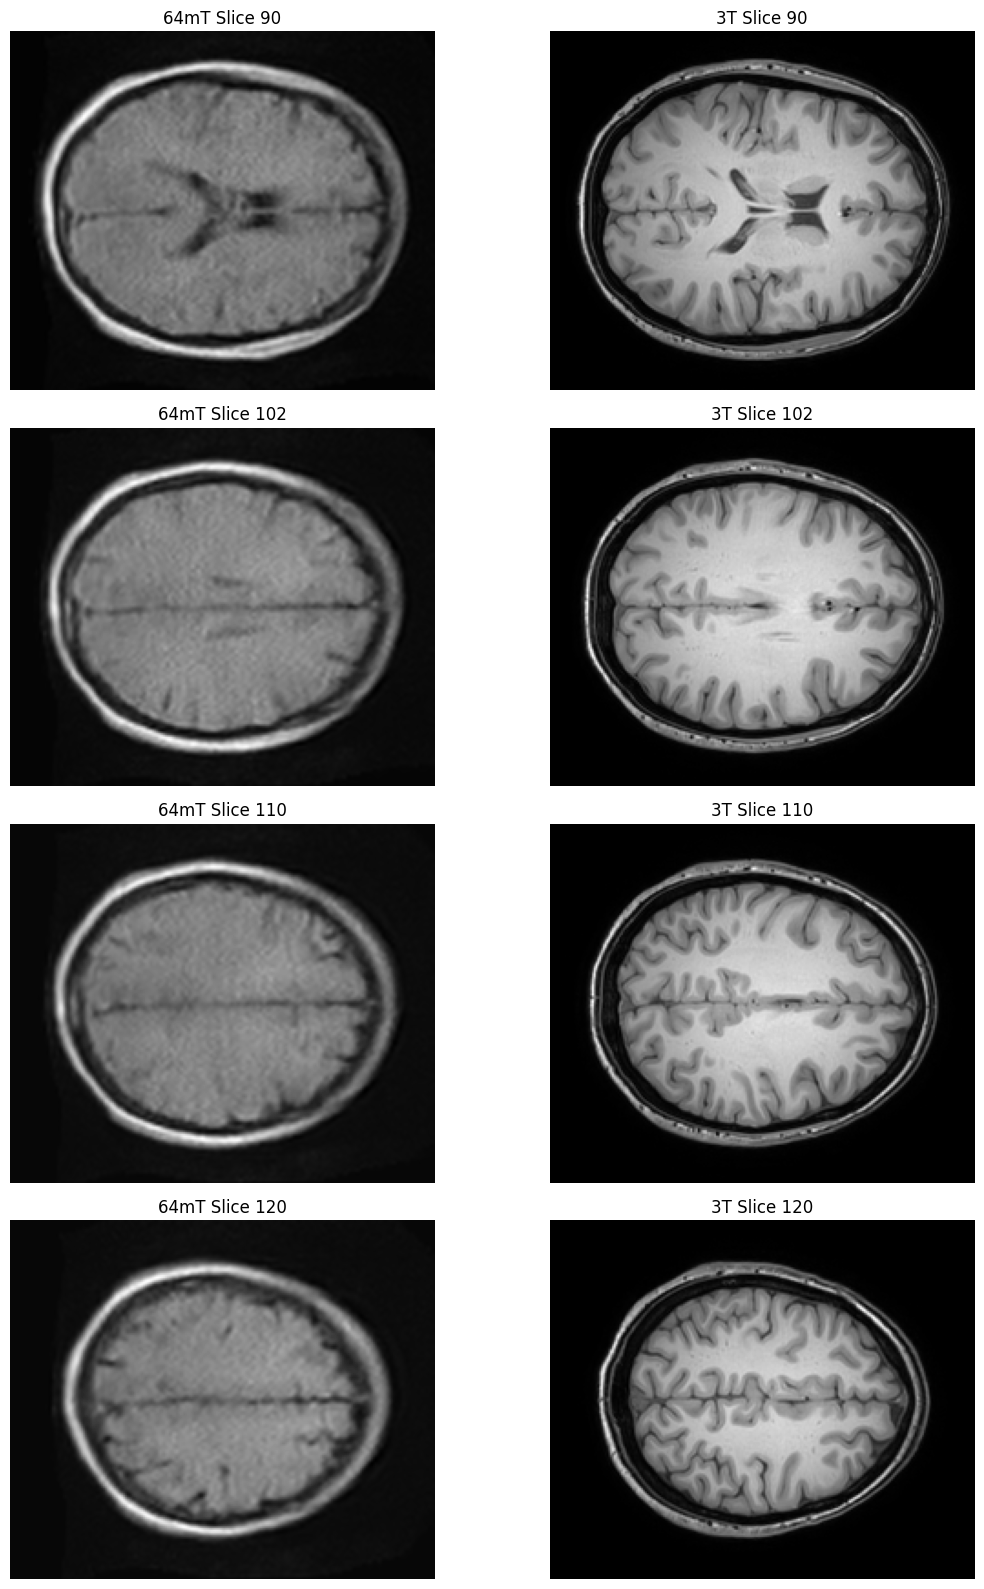

In [ ]:
def plot_paired_images_grid(array1, array2, slice_idxs, titles=None, figsize=(12, 4)):
    """
    Plots a grid of paired images from two arrays for the given slice indices.
    
    Args:
        array1 (ndarray): First 3D image array.
        array2 (ndarray): Second 3D image array.
        slice_idxs (list): List of indices to use for the third dimension (z-slices).
        titles (list): Optional. List of (title1, title2) pairs for each row.
        figsize (tuple): Figure size.
    """
    n = len(slice_idxs)
    fig, axes = plt.subplots(n, 2, figsize=figsize if n == 1 else (figsize[0], figsize[1]*n))
    if n == 1:
        axes = [axes]  # in case n==1 makes axes a 1D array
    for i, idx in enumerate(slice_idxs):
        ax1, ax2 = axes[i]
        ax1.imshow(array1[:, :, idx], cmap='gray')
        ax2.imshow(array2[:, :, idx], cmap='gray')
        if titles:
            ax1.set_title(titles[i][0])
            ax2.set_title(titles[i][1])
        ax1.axis('off')
        ax2.axis('off')
    plt.tight_layout()
    plt.show()

# Example
# convert from ants.ANTsImage to numpy array
Array_64mT = registered_64mT.numpy()
Array_3T = registered_3T.numpy()

plot_paired_images_grid(
    Array_64mT,
    Array_3T,
    slice_idxs=[90, 102, 110, 120], 
    titles=[('64mT Slice 90', '3T Slice 90'),
            ('64mT Slice 102', '3T Slice 102'),
            ('64mT Slice 110', '3T Slice 110'),
            ('64mT Slice 120', '3T Slice 120')]
)

---
## 4. Save Individual Slices as PNGs

With the registration complete, we can now save all the files for further downstream work in the hackathon as PNGs. Export each slice as a PNG file for use in downstream tasks (e.g. training, visualisation).

In [ ]:
def save_slices_as_png(data, output_dir, prefix='slice') -> None:
    """
    Save each z-slice as a PNG. Creates output_dir if it doesn't exist.

    Args:
        data (ndarray): The 3D image array.
        output_dir (str): The directory to save the PNG files.
        prefix (str): The prefix for the PNG files.
    """
    os.makedirs(output_dir, exist_ok=True)
    n_slices = data.shape[2]
    for i in range(n_slices):
        slice_img = data[:, :, i]
        # Normalise to 0–1 for matplotlib save
        if slice_img.max() > slice_img.min():
            slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min())
        else:
            slice_img = np.zeros_like(slice_img)
        plt.imsave(os.path.join(output_dir, f'{prefix}_{i:04d}.png'), slice_img, cmap='gray')
    print(f"Saved {n_slices} slices to {output_dir}")


# save the aligned slices of the 64mT image 
save_slices_as_png(
    Array_64mT, os.path.join(OUT_DIR, '64mT_aligned'), prefix='64mT_aligned_file_1')

# save the aligned slices of the 3T image 
save_slices_as_png(
    Array_3T, os.path.join(OUT_DIR, '3T_aligned'), prefix='3T_aligned_file_1')



Saved 189 slices to /Users/luca/Downloads/HackathonPaired/outouts/64mT_aligned
Saved 189 slices to /Users/luca/Downloads/HackathonPaired/outouts/3T_aligned
